In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn.linear_model
import xgboost as xgb
from pytil.object import Namespace as O
from pytil.utility import *
from helpers import *
from pytil.quickvis import canvas

import random
ss = slice(None)
canvas(16, 2)

In [2]:
N_TRAIN, N_TEST = 623817, 640430
df = pd.read_csv('train.csv', index_col=0)
df.index = df.index - N_TRAIN
dg = pd.read_csv('test.csv', index_col=0)

# Explore

In [3]:
xfeats = 'x0 x1 x2 x3A x3B x3C x3D x3E x4 x5 x6'.split()

In [292]:
grp = df.groupby(['Market', 'Stock'])
desc = grp.describe()

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-29 22:22:11.674487. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [724]:
agrp = np.abs(df).groupby('Market Stock'.split())
wycorr = agrp.corr().loc[(slice(None), slice(None), 'Weight',), ('y',)]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:16.747078. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


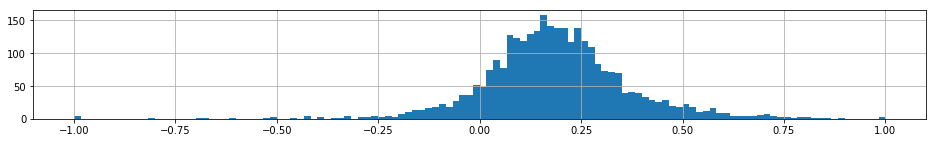

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:31.051520. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [725]:
res = agrp.corr().loc[(ss, ss, 'y'), 'x4']
res.hist(bins=120)

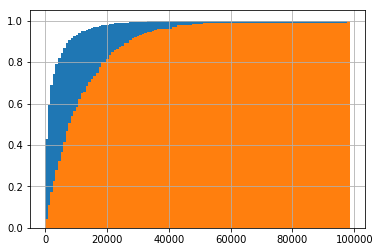

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 09:11:33.695777. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [341]:
hist(grp.sum().Weight, bins=120, normed=True, cumulative=True)
hist(grp.sum().Weight, weighted=True, bins=120, normed=True, cumulative=True)

In [394]:
listthing = [int(x[0]) for x in sorted(df[['Stock', col]].values, key=lambda x: x[1])[::-1][-1000:-500]]
thing = list(set(listthing))

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 10:21:28.672423. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


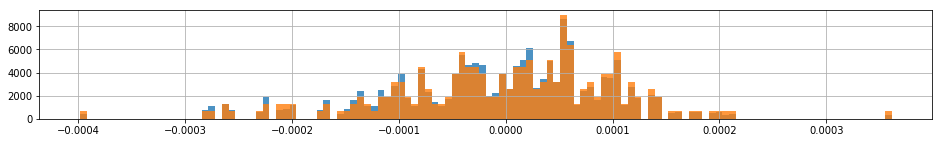

247 0.000397538089951


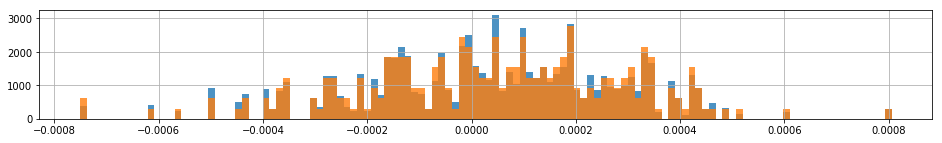

251 0.0867626267151


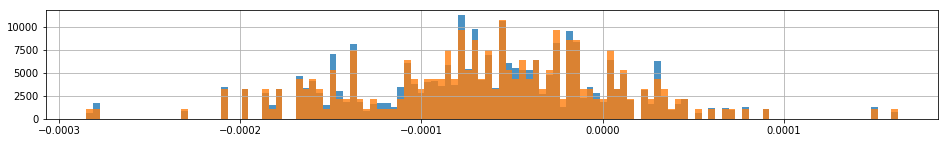

251 0.204674285411


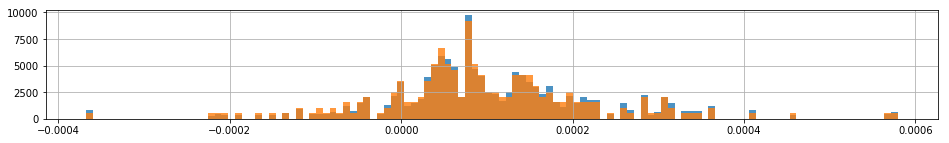

247 1.42622882884e-05


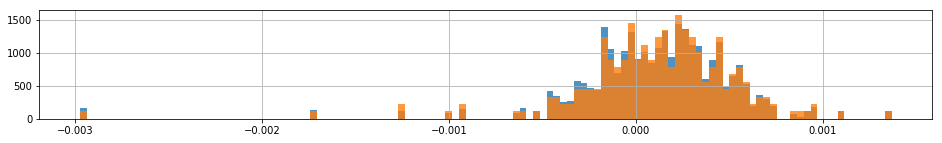

247 1.6676556502e-31


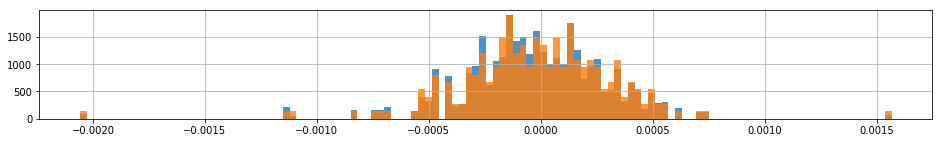

247 9.22979973834e-14


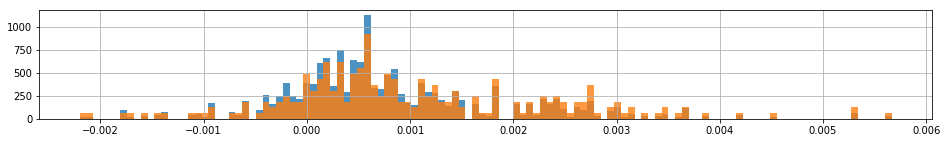

249 9.59286090927e-06


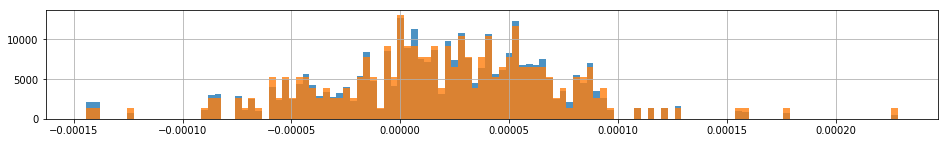

247 0.0197578412492


C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:25:03.178891. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [744]:
col = 'y'
from scipy import stats
ii = list(range(df.Stock.min(), df.Stock.max() + 1))
random.shuffle(ii)
ii = ii[:8]
#ii = thing
for i in range(len(ii)):
    q = df.query('Stock == ' + str(ii[i]))
    trans = q[col]
    trans.hist(bins=120, weights=q.Weight, normed=True, alpha=.8)
    trans.hist(bins=120, normed=True, alpha=.8)
    plt.show()
    print(len(trans), stats.normaltest(trans).pvalue)

## cv days selection

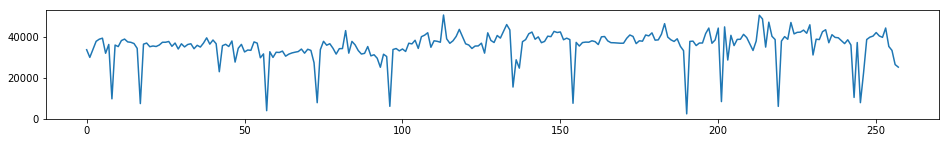

In [84]:
days = sorted(set(df.Day))
weights = [df.query('Day == ' + str(day)).Weight.sum() for day in days]
plt.plot(weights); plt.show()

# Simple model

In [4]:
dh = pd.concat([df, dg])

In [5]:
market = pd.get_dummies(dh[['Market']], columns=['Market'])
stock = pd.get_dummies(dh[['Stock']], columns=['Stock'])
day = pd.get_dummies(dh[['Day']], columns=['Day'])

In [6]:
wkdfeats = 'Monday Tuesday Wednesday Thursday Friday'.split()
weekday = ((dh.Day + 2) % 7)
weekday = weekday.map({i: s for i, s in enumerate(wkdfeats)})
weekday = pd.get_dummies(weekday)
weekday = weekday[wkdfeats]

In [18]:
ranked = 1 - dh.groupby(['Market', 'Stock']).transform(lambda x: x.rank(pct=True, method='max', ascending=False))
ranked = ranked[[c for c in ranked.columns if c != 'Weight' and c != 'y' and c != 'Day']]
ranked.columns = [c + ' rank' for c in ranked.columns]

In [ ]:
# 

In [8]:
days = sorted(set(df.Day))
random.shuffle(days)
n_days = len(days)
days_a, days_b = set(days[:n_days // 2]), set(days[n_days // 2:])
tr, cv = df.Day.isin(days_a), df.Day.isin(days_b)

In [26]:
origdh = dh[['Market', 'Stock'] + xfeats]
thedh = pd.concat([market, stock, weekday, origdh], axis=1)

In [27]:
xdf = thedh.iloc[:N_TRAIN]
labels = list(xdf.columns)
n = len(df)
x = xdf.values
y = df.y.values
weight = df.Weight.values

In [31]:
n = len(df)
a = list(range(n))
random.shuffle(a)
tr, cv = a[:n // 2], a[n // 2:]

In [32]:
dmat = O()
dmat.tr = xgb.DMatrix(x[tr], y[tr], feature_names=labels, weight=weight[tr])
dmat.cv = xgb.DMatrix(x[cv], y[cv], feature_names=labels, weight=weight[cv])

In [33]:
model = None
boost_hp = dict(
    objective = 'reg:linear',
    booste = 'gbtree',
    max_depth = 9,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    tree_method = 'exact',
    gamma = 0,
    min_child_weight = 0,
    eta = 0.2,
    seed = 0
)
cv_hp = dict(
    num_boost_round = 500,
    early_stopping_rounds = 50,
    nfold = 10,
    stratified = True,
    seed = 0,
)
learn_hp = dict(
    num_boost_round = 500,
    early_stopping_rounds = 50,
    evals = [[dmat.cv, 'CV']]
)
model = xgb.train(boost_hp, dmat.tr, **learn_hp)

[0]	CV-rmse:0.399989
Will train until CV-rmse hasn't improved in 50 rounds.
[1]	CV-rmse:0.319991
[2]	CV-rmse:0.255993
[3]	CV-rmse:0.204794
[4]	CV-rmse:0.163836
[5]	CV-rmse:0.131069
[6]	CV-rmse:0.104855
[7]	CV-rmse:0.083884
[8]	CV-rmse:0.067108
[9]	CV-rmse:0.053686
[10]	CV-rmse:0.042949
[11]	CV-rmse:0.03436
[12]	CV-rmse:0.027488
[13]	CV-rmse:0.021991
[14]	CV-rmse:0.017594
[15]	CV-rmse:0.014076
[16]	CV-rmse:0.011262
[17]	CV-rmse:0.009011
[18]	CV-rmse:0.007211
[19]	CV-rmse:0.005771
[20]	CV-rmse:0.004619
[21]	CV-rmse:0.003699
[22]	CV-rmse:0.002964
[23]	CV-rmse:0.002376
[24]	CV-rmse:0.001908
[25]	CV-rmse:0.001535
[26]	CV-rmse:0.001238
[27]	CV-rmse:0.001003
[28]	CV-rmse:0.000818
[29]	CV-rmse:0.000674
[30]	CV-rmse:0.000562
[31]	CV-rmse:0.000477
[32]	CV-rmse:0.000413
[33]	CV-rmse:0.000367
[34]	CV-rmse:0.000334
[35]	CV-rmse:0.000311
[36]	CV-rmse:0.000296
[37]	CV-rmse:0.000285
[38]	CV-rmse:0.000278
[39]	CV-rmse:0.000273
[40]	CV-rmse:0.00027
[41]	CV-rmse:0.000269
[42]	CV-rmse:0.000267
[43]	CV-rms

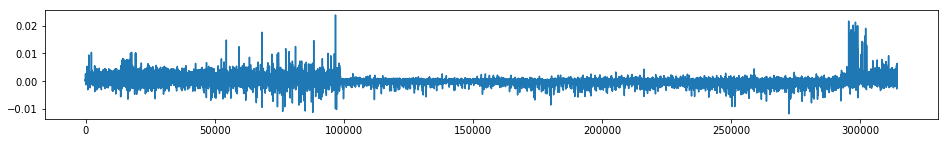

In [14]:
y_ = model.predict(dmat.cv)
plt.plot(y_);

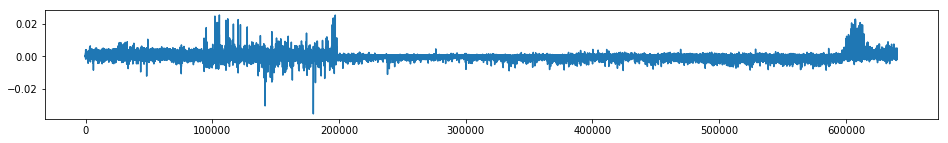

In [15]:
xtest = thedh.iloc[N_TRAIN:].values
dmat.test = xgb.DMatrix(xtest, feature_names=labels)
ytest_ = model.predict(dmat.test)
plt.plot(ytest_);

In [ ]:
for i, tree in enumerate(model.get_dump()):
    print('<{}>'.format(i))
    print(tree)
    if i >= 10:
        break

In [16]:
ypred = pd.Series(ytest_).rename('y')
ypred.index.name = 'Index'
ypred.to_csv('model1.csv', header=True)
with open('days_order.txt', 'w') as file:
    print('\n'.join(str(x) for x in days), file=file)
omodel = model
odays = days

In [30]:
sorted(model.get_score().items(), key=lambda x: -x[1])

[('x0', 1078),
 ('x4', 994),
 ('x3A', 868),
 ('x1', 814),
 ('x2', 800),
 ('x5', 774),
 ('x3E', 696),
 ('x3D', 691),
 ('x3B', 564),
 ('x6', 499),
 ('x3C', 492),
 ('Tuesday', 174),
 ('Market_1', 163),
 ('Monday', 141),
 ('Wednesday', 140),
 ('Stock', 130),
 ('Thursday', 126),
 ('Friday', 121),
 ('Market_2', 62),
 ('Market_4', 41),
 ('Market_3', 39),
 ('Stock_51', 25),
 ('Stock_1540', 20),
 ('Stock_1099', 17),
 ('Stock_2251', 17),
 ('Stock_793', 15),
 ('Stock_499', 14),
 ('Stock_1393', 13),
 ('Stock_1045', 13),
 ('Stock_347', 12),
 ('Stock_2652', 10),
 ('Stock_507', 10),
 ('Stock_2865', 10),
 ('Stock_748', 10),
 ('Stock_829', 10),
 ('Stock_1696', 9),
 ('Stock_1316', 9),
 ('Stock_35', 9),
 ('Stock_0', 9),
 ('Stock_493', 8),
 ('Stock_2708', 8),
 ('Stock_1855', 8),
 ('Stock_959', 8),
 ('Stock_2470', 7),
 ('Stock_2372', 7),
 ('Stock_2793', 7),
 ('Stock_2596', 7),
 ('Stock_2304', 7),
 ('Stock_1805', 7),
 ('Stock_2432', 7),
 ('Stock_1302', 7),
 ('Stock_176', 7),
 ('Stock_1508', 6),
 ('Stock_819

In [24]:
sorted(omodel.get_score().items(), key=lambda x: -x[1])

[('x0', 815),
 ('x4', 737),
 ('x1', 634),
 ('x3A', 614),
 ('x2', 582),
 ('x5', 563),
 ('x3D', 478),
 ('x3E', 446),
 ('Day rank', 435),
 ('x3C', 371),
 ('x3B', 366),
 ('x6', 313),
 ('x6 rank', 194),
 ('Market_1', 154),
 ('x3A rank', 146),
 ('x4 rank', 135),
 ('x3D rank', 126),
 ('x0 rank', 125),
 ('Tuesday', 123),
 ('Wednesday', 123),
 ('x3E rank', 115),
 ('x5 rank', 114),
 ('Monday', 114),
 ('x2 rank', 108),
 ('Thursday', 96),
 ('Stock', 93),
 ('x1 rank', 81),
 ('Friday', 80),
 ('x3B rank', 69),
 ('x3C rank', 68),
 ('Market_3', 51),
 ('Market_4', 47),
 ('Market_2', 42),
 ('Stock_51', 24),
 ('Stock_1099', 15),
 ('Stock_2652', 14),
 ('Stock_793', 13),
 ('Stock_2372', 13),
 ('Stock_347', 13),
 ('Stock_499', 12),
 ('Stock_1045', 12),
 ('Stock_2745', 12),
 ('Stock_1540', 11),
 ('Stock_0', 11),
 ('Stock_2251', 11),
 ('Stock_959', 11),
 ('Stock_414', 10),
 ('Stock_829', 10),
 ('Stock_1393', 9),
 ('Stock_1696', 9),
 ('Stock_507', 9),
 ('Stock_634', 9),
 ('Stock_1316', 8),
 ('Stock_1400', 8),
 

## predict y-rank

# Split model

# Abs model